# Moving Average Crossover Strategy
 Concept: Buy when a short-term moving average (e.g., 10-day MA) crosses above a long-term moving average (e.g., 50-day MA), and sell when it crosses below.

* Type: Trend-following

* Assets: Stocks, ETFs, crypto

* Pros: Simple, widely used

* Cons: Can produce whipsaws in sideways markets

## Import Libraries

In [33]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import yfinance as yf
from datetime import date
from itertools import product

from trading_algos.moving_average_crossover import plot_windows, plot_strategy

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Data From YFinance

In [2]:
# Retrieve the latest stock data from YFinance
df_aapl = yf.download('AAPL', start='2020-01-01')

df_aapl.head()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2020-01-02,72.620842,72.681289,71.373218,71.627092,135480400
2020-01-03,71.914818,72.676447,71.689957,71.847118,146322800
2020-01-06,72.487846,72.526533,70.783248,71.034709,118387200
2020-01-07,72.146927,72.753808,71.926900,72.497514,108872000
2020-01-08,73.307510,73.609745,71.849533,71.849533,132079200


In [3]:
# Restructure the data so that it is simple and reusable to work with
df = df_aapl.droplevel(axis=1, level=1)['Close'].to_frame()

df.head()

,Close
Date,
2020-01-02,72.620842
2020-01-03,71.914818
2020-01-06,72.487846
2020-01-07,72.146927
2020-01-08,73.307510


## Developing The Strategy

### Create The Rolling Windows
* These will be used to flag our buy and sell signals
* When the short window is above the long, we buy
* When the long window is above the short, we sell

In [4]:
# Generate the short moving average window using 50 days here
df['sma_short'] = df['Close'].rolling(50).mean()

# Generate the long moving average window using 200 days here
df['sma_long'] = df['Close'].rolling(200).mean()

# Remove data that is missing due to lack of periodic data
df = df.dropna()

df.head()


,Close,sma_short,sma_long
Date,,,
2020-10-15,117.550018,113.858167,86.063326
2020-10-16,115.904243,113.961830,86.279743
2020-10-19,112.943840,114.056631,86.484889
2020-10-20,114.433792,114.149777,86.694618
2020-10-21,113.810547,114.295752,86.902936


### Visualize The Rolling Windows Against Price

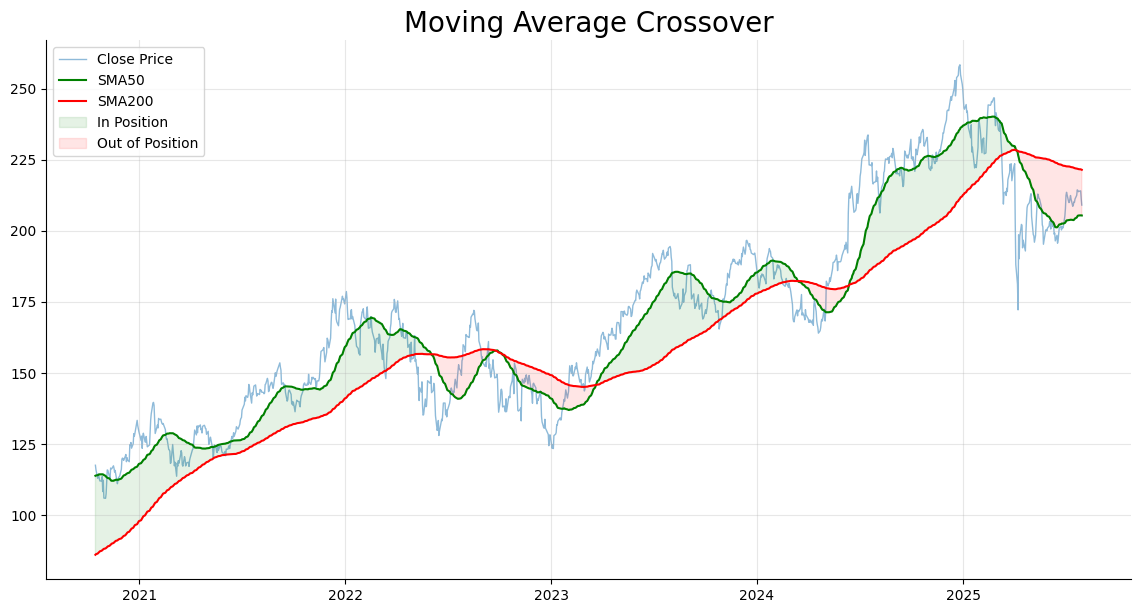

In [5]:
fig, ax = plt.subplots(figsize=(14,7))

ax.set_title('Moving Average Crossover', fontsize=20)
ax.plot(df['Close'], label='Close Price', linestyle='-', linewidth=1, alpha=0.5, zorder=1)
ax.plot(df['sma_short'], label='SMA50', color='Green', alpha=1, zorder=2)
ax.plot(df['sma_long'], label='SMA200', color='Red', alpha=1, zorder=3)
ax.spines[["top", "right"]].set(visible=False)
ax.grid(alpha=0.3)

ax.fill_between(df.index,
                    df['sma_short'],
                    df['sma_long'],
                    where=(df['sma_short'] > df['sma_long']),
                    color='Green',
                    alpha=0.1,
                    label="In Position")

ax.fill_between(df.index,
                    df['sma_short'],
                    df['sma_long'],
                    where=(df['sma_short'] < df['sma_long']),
                    color='Red',
                    alpha=0.1,
                    label="Out of Position")

ax.legend(loc='upper left')

plt.show;

### Generate Buy & Sell Signals To Indicate When We Are In Position

In [6]:
# If the short signal rises above the long signal, then we are in a buying position
df['signal'] = (df['sma_short'] > df['sma_long']) * 1

df.head()

,Close,sma_short,sma_long,signal
Date,,,,
2020-10-15,117.550018,113.858167,86.063326,1
2020-10-16,115.904243,113.961830,86.279743,1
2020-10-19,112.943840,114.056631,86.484889,1
2020-10-20,114.433792,114.149777,86.694618,1
2020-10-21,113.810547,114.295752,86.902936,1


### Visualizing Buy & Sell Positions Against Price Data

In [7]:
# Using diff to indicate if the position has changed from the previous day
# Ensuring to capture the original position using fillna
markers = df['signal'].diff().fillna(df['signal'].iloc[0])

# A buy marker will have a diff of 1 from the previous day (up to 1 from 0)
buy_markers = markers[markers == 1]

# A sell marker will have a diff of -1 from the previous day (down to 0 from 1)
sell_markers = markers[markers == -1]

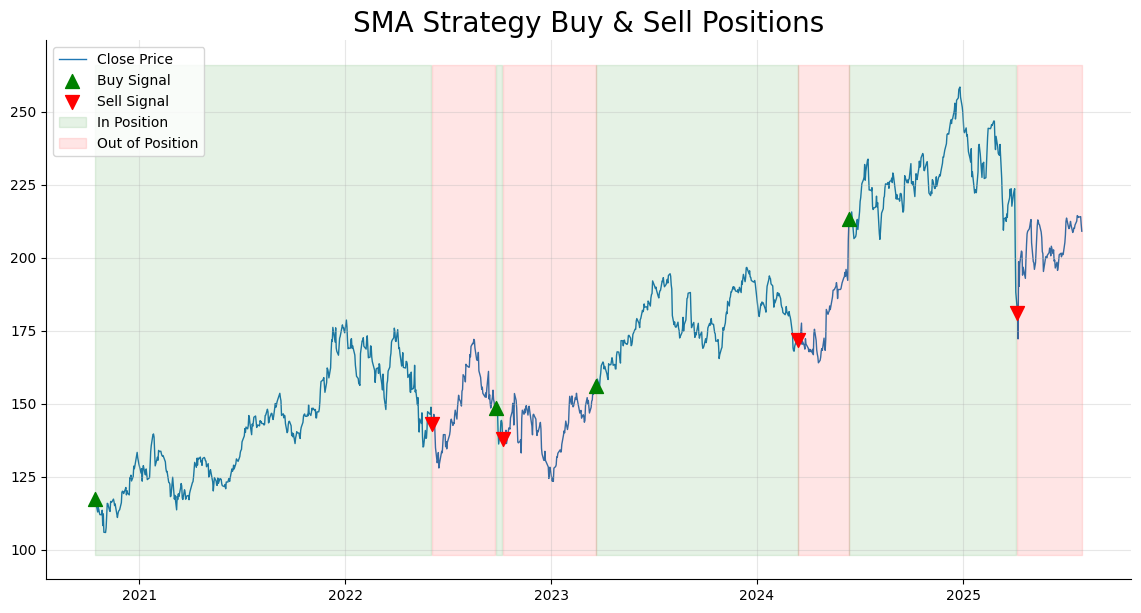

In [8]:
fig, ax = plt.subplots(figsize=(14,7))

ax.set_title('SMA Strategy Buy & Sell Positions', fontsize=20)
ax.plot(df['Close'], label='Close Price', linestyle='-', linewidth=1, alpha=1, zorder=1)
ax.scatter(x=buy_markers.index, y=df['Close'].loc[buy_markers.index], marker='^', s=100, color='Green', label='Buy Signal', zorder=4)
ax.scatter(x=sell_markers.index, y=df['Close'].loc[sell_markers.index], marker='v', s=100, color='Red', label='Sell Signal', zorder=5)
ax.spines[["top", "right"]].set(visible=False)
ax.grid(alpha=0.3)

y_min, y_max = ax.get_ybound()

ax.fill_between(df.index,
                y_max,
                y_min,
                where=(df['sma_short'] > df['sma_long']),
                color='Green',
                alpha=0.1,
                label='In Position')

ax.fill_between(df.index,
                y_max,
                y_min,
                where=(df['sma_short'] < df['sma_long']),
                color='Red',
                alpha=0.1,
                label='Out of Position')

# Prevents duplicate keys being added to the legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc="upper left")

plt.show;

### Calculating Strategy Returns

In [9]:
# Once the short closes above the long we will move into position
df['position'] = df['signal'].shift(1)

df.head()

,Close,sma_short,sma_long,signal,position
Date,,,,,
2020-10-15,117.550018,113.858167,86.063326,1,NaN
2020-10-16,115.904243,113.961830,86.279743,1,1.0
2020-10-19,112.943840,114.056631,86.484889,1,1.0
2020-10-20,114.433792,114.149777,86.694618,1,1.0
2020-10-21,113.810547,114.295752,86.902936,1,1.0


In [10]:
# First we calculate the daily price change of the stock
df['price_ret'] = df['Close'].pct_change()

df.head()

,Close,sma_short,sma_long,signal,position,price_ret
Date,,,,,,
2020-10-15,117.550018,113.858167,86.063326,1,NaN,NaN
2020-10-16,115.904243,113.961830,86.279743,1,1.0,-0.014001
2020-10-19,112.943840,114.056631,86.484889,1,1.0,-0.025542
2020-10-20,114.433792,114.149777,86.694618,1,1.0,0.013192
2020-10-21,113.810547,114.295752,86.902936,1,1.0,-0.005446


In [11]:
# Our strategy returns will match the daily price movements only when we are in position
df['strategy_ret'] = df['position'] * df['price_ret']

df.head()

,Close,sma_short,sma_long,signal,position,price_ret,strategy_ret
Date,,,,,,,
2020-10-15,117.550018,113.858167,86.063326,1,NaN,NaN,NaN
2020-10-16,115.904243,113.961830,86.279743,1,1.0,-0.014001,-0.014001
2020-10-19,112.943840,114.056631,86.484889,1,1.0,-0.025542,-0.025542
2020-10-20,114.433792,114.149777,86.694618,1,1.0,0.013192,0.013192
2020-10-21,113.810547,114.295752,86.902936,1,1.0,-0.005446,-0.005446


In [12]:
# We can now calculate the cumulitive returns over time
df['price_cum_ret'] = (1 + df['price_ret']).cumprod()
df['strategy_cum_ret'] = (1 + df['strategy_ret']).cumprod()

df.head()

,Close,sma_short,sma_long,signal,position,price_ret,strategy_ret,price_cum_ret,strategy_cum_ret
Date,,,,,,,,,
2020-10-15,117.550018,113.858167,86.063326,1,NaN,NaN,NaN,NaN,NaN
2020-10-16,115.904243,113.961830,86.279743,1,1.0,-0.014001,-0.014001,0.985999,0.985999
2020-10-19,112.943840,114.056631,86.484889,1,1.0,-0.025542,-0.025542,0.960815,0.960815
2020-10-20,114.433792,114.149777,86.694618,1,1.0,0.013192,0.013192,0.973490,0.973490
2020-10-21,113.810547,114.295752,86.902936,1,1.0,-0.005446,-0.005446,0.968188,0.968188


### Visualizing Buy & Hold Versus Strategy Returns

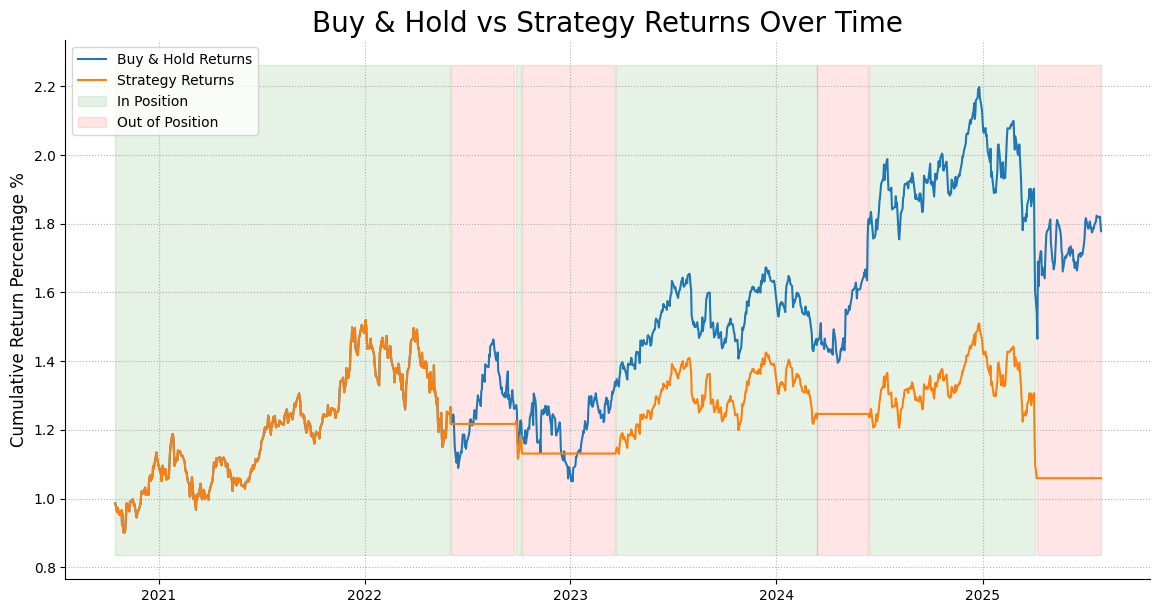

In [13]:
fig, ax = plt.subplots(figsize=(14,7))
# ax.plot(df_aapl['Close'])
ax.set_title("Buy & Hold vs Strategy Returns Over Time", fontsize=20)
ax.set_ylabel("Cumulative Return Percentage %", fontsize=12)
ax.plot(df['price_cum_ret'], label='Buy & Hold Returns')
ax.plot(df['strategy_cum_ret'], label='Strategy Returns')
ax.grid(alpha=1, linestyle=":")
ax.spines[["top", "right"]].set(visible=False)

y_min, y_max = ax.get_ybound()

ax.fill_between(df.index,
                y_max,
                y_min,
                where=(df['sma_short'] > df['sma_long']),
                color='Green',
                alpha=0.1,
                label='In Position')

ax.fill_between(df.index,
                y_max,
                y_min,
                where=(df['sma_short'] < df['sma_long']),
                color='Red',
                alpha=0.1,
                label='Out of Position')

ax.legend(loc="upper left")

plt.show;

### Writing a Function To Do All Of The Above

In [14]:
def backtest_ma_strategy(df_stock: pd.DataFrame = pd.DataFrame(),
                         price_col: str = 'Close',
                         ticker: str = "AAPL",
                         start: str = str(date.today().year - 5) + "-01-01",
                         end: str = str(date.today()),
                         short_window: int = 50,
                         long_window: int = 200,
):
    """
    Backtest a simple moving average trading strategy.

        df: A DataFrame Containing Price Data

        price_col: The column within the specified df that contains ticker price data
            default = 'Close'

        ticker: If a df is not provided then data for this ticker will be downloaded within a specified date range
            default = 'AAPL'

        start: If downloading fresh data then this is the start date of the period for which price data will be pulled
            default = The beginning of the year of today - 5

        end: If downloading fresh data then this is the end date of the period for which price data will be pulled
            default = today

        short_window: The short SMA rolling window length
            defaullt = 50

        long_window: The long SMA rolling window length
            default = 200
    """

    # If a dataframe containing price data is not provided then download the latest data from Yahoo Finance
    if df_stock.empty:
        # Ensure that we have a ticker
        if ticker == None:
            print('Ticker Needed')
            return

        # Download Ticker Price Data
        df_stock = yf.download(ticker, start=start, end=end)

        # Restructure data
        df = df_stock.droplevel(axis=1, level=1)[price_col].to_frame()
    else:
        df = df_stock.copy()

    # Short Signal
    df['sma_short'] = df[price_col].rolling(window=short_window).mean()
    # Long Signal
    df['sma_long'] = df[price_col].rolling(window=long_window).mean()
    # Drop rows where signals are missing due to lack of data
    df.dropna(inplace=True)

    # When the short window closes above the long window, flag a buy signal
    df['signal'] = (df['sma_short'] > df['sma_long']) * 1
    # Position the days trade based on the previous close signal
    df['position'] = df['signal'].shift(1)

    # The daily price change of the stock
    df['price_ret'] = df[price_col].pct_change()
    # The price change of the stock, only accounting for days we are in position
    df['strategy_ret'] = df['position'] * df['price_ret']

    # The return on investment if we had bought and held from the start date
    df['price_cum_ret'] = (1 + df['price_ret']).cumprod()
    # The return on investment if we had traded and held the the stock signal
    df['strategy_cum_ret'] = (1 + df['strategy_ret']).cumprod()

    return df

In [15]:
df_backtest = backtest_ma_strategy(df_stock=df_aapl.droplevel(axis=1, level=1)['Close'].to_frame())
df_backtest.head()

,Close,sma_short,sma_long,signal,position,price_ret,strategy_ret,price_cum_ret,strategy_cum_ret
Date,,,,,,,,,
2020-10-15,117.550018,113.858167,86.063326,1,NaN,NaN,NaN,NaN,NaN
2020-10-16,115.904243,113.961830,86.279743,1,1.0,-0.014001,-0.014001,0.985999,0.985999
2020-10-19,112.943840,114.056631,86.484889,1,1.0,-0.025542,-0.025542,0.960815,0.960815
2020-10-20,114.433792,114.149777,86.694618,1,1.0,0.013192,0.013192,0.973490,0.973490
2020-10-21,113.810547,114.295752,86.902936,1,1.0,-0.005446,-0.005446,0.968188,0.968188


In [16]:
# Quality check to ensure that the backtesting function matches prior logic
df_backtest.equals(df)

True

### Calculating Risk vs Return

In [17]:
# Return average return on investment
# Riskk is how far this is likely to swing from day to day, i.e. volatility
summary = df_backtest[["price_ret", "strategy_ret"]].agg(["mean", "std"]).T
summary.columns = ["return", "risk"]
summary

,return,risk
price_ret,0.000640,0.01795
strategy_ret,0.000147,0.01408


In [18]:
# Risk & Return can be annualized by accounting for the number of trading days wihtin a year, 252 as standard
ann_summary = summary * (252, np.sqrt(252))
ann_summary

,return,risk
price_ret,0.161216,0.284943
strategy_ret,0.037150,0.223513


### The Sharpe Ratio
* The sharpe ratio is an indication of a stock or a strategies performance, it is a measure of risk versus return
* The higher the sharpe ratio, the better the investment

In [19]:
# The risk free return is the return on an investment that is deemed to be risk free
# These are usually government bonds given by stable countries such as the US, Germany, or the UK
risk_free_return = 0.05

In [20]:
# The Sharpe ratio compares investment reward against risk
# The higher the Sharpe ratio, the better the investment as the reward to risk ratio is stronger
ann_summary["sharpe"] = (ann_summary["return"] - risk_free_return) / ann_summary["risk"]
ann_summary

,return,risk,sharpe
price_ret,0.161216,0.284943,0.390311
strategy_ret,0.037150,0.223513,-0.057492


* Our Strategy isn't a very good one, we would have been better to buy and hold the AAPL stock instead of trying to trade it using this method.
* Whilst our strategy is slightly less risky, the returns are much worse.
* I believe that this is due to missing out on initial price movements as the trend lines we use to signal trades lag behind actual price movements, so we are often late to capitalise on trend reversals
* Perhaps shorter windows will improve the strategy as they will follow price movements more closely

### Writing A Function to Summarize Annual Returns and Sharpe Ratio

In [21]:
def get_summary(df: pd.DataFrame = pd.DataFrame()):

    summary = df.agg(["mean", "std"]).T.copy()
    summary.columns = ["return", "risk"]

    return summary

In [22]:
def get_ann_summary(df: pd.DataFrame = pd.DataFrame(),
                       periods_in_year: int = 252,
                       rfr: float = 0.05):

    ann_summary = get_summary(df) * (periods_in_year, np.sqrt(periods_in_year))
    ann_summary["sharpe"] = (ann_summary["return"] - rfr) / ann_summary["risk"]

    return ann_summary

In [23]:
get_ann_summary(df_backtest[["price_ret", "strategy_ret"]])

,return,risk,sharpe
price_ret,0.161216,0.284943,0.390311
strategy_ret,0.037150,0.223513,-0.057492


### Using a Gridsearch to Optimize Strategy Performance and Find the Strategy With the Best Sharpe Ratio

In [24]:
def grid_search_sma(df,
                    short_range: range=range(5, 55, 5),
                    long_range: range=range(20, 210, 10)):

    """
    Perform grid search over SMA window ranges.
    """


    # Inititalize results
    best_score = -np.inf
    best_params = None
    results = []

    # Loop through each parameter combination
    for short_window, long_window in product(short_range, long_range):
        
        # Ensure short < long to avoid logic error
        if short_window >= long_window:
            continue 

        # Backtest the strategy using the updated parameters and capture the performance metrics
        strategy_data = backtest_ma_strategy(df_stock=df, short_window=short_window, long_window=long_window)
        score = get_ann_summary(strategy_data['strategy_ret'].to_frame())['sharpe']['strategy_ret']
        results.append(((short_window, long_window), score))

        # Update the best params and best score if the latest backtest out performs what is currently held
        if score > best_score:
            best_score = score
            best_params = (short_window, long_window)

    return best_params, best_score, results

In [25]:
# Test the short range parameter between 5 & 50 day rolling averages, incrementing by steps of 5
short_range = range(5, 55, 5)

# Test the long range parameter between 20 & 200 day rolling averages, incrementing by steps of 10
long_range = range(20, 210, 10)

In [26]:
best_params, best_score, results = grid_search_sma(df=df_aapl, short_range=short_range, long_range=long_range)

In [27]:
# Convert results to DataFrame for plotting
result_df = pd.DataFrame([
    {'Short': p[0], 'Long': p[1], 'Sharpe': s}
    for p, s in results
])

result_df.sort_values('Sharpe', ascending=False)

,Short,Long,Sharpe
110,35,40,0.680704
7,5,90,0.624334
60,20,60,0.618013
25,10,80,0.617656
4,5,60,0.603295
...,...,...,...
169,50,160,-0.019014
126,35,200,-0.040721
123,35,170,-0.055145
173,50,200,-0.057492


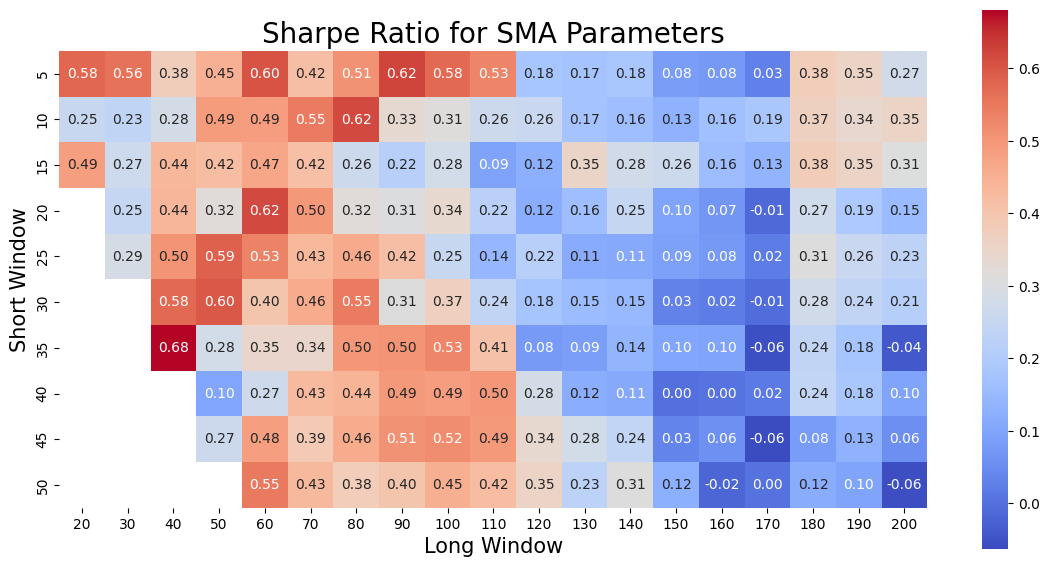

In [59]:
pivot = result_df.pivot(index='Short', columns='Long', values='Sharpe')
plt.figure(figsize=(14, 7))
sns.heatmap(pivot, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("Sharpe Ratio for SMA Parameters", fontsize=20)
plt.ylabel("Short Window", fontsize=15)
plt.xlabel("Long Window", fontsize=15)
plt.show()

### Testing the optimal Parameters

In [71]:
df_optimal = backtest_ma_strategy(df_stock=df_aapl, short_window=35, long_window=40)
df_optimal

Price,Close,High,Low,Open,Volume,sma_short,sma_long,signal,position,price_ret,strategy_ret,price_cum_ret,strategy_cum_ret
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,,,,,,,,
Date,,,,,,,,,,,,,
2020-02-28,66.251831,67.475759,62.134118,62.349823,426510000,75.826122,75.409805,1,NaN,NaN,NaN,NaN,NaN
2020-03-02,72.419960,73.057371,67.308562,68.413729,341397200,75.756275,75.404783,1,1.0,0.093101,0.093101,1.093101,1.093101
2020-03-03,70.119942,73.677802,69.266826,73.597826,319475600,75.615877,75.359912,1,1.0,-0.031759,-0.031759,1.058385,1.058385
2020-03-04,73.372429,73.532388,71.043341,71.845556,219178400,75.522606,75.382026,1,1.0,0.046385,0.046385,1.107478,1.107478
2020-03-05,70.992447,72.599295,70.626479,71.622580,187572800,75.390903,75.353164,1,1.0,-0.032437,-0.032437,1.071554,1.071554
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-07-24,213.759995,215.690002,213.529999,213.899994,46022600,205.729428,205.168000,1,1.0,-0.001821,-0.001821,3.226477,2.646856
2025-07-25,213.880005,215.240005,213.399994,214.699997,40268800,206.045428,205.504500,1,1.0,0.000561,0.000561,3.228288,2.648342


(<Figure size 1400x700 with 1 Axes>,
 <Axes: title={'center': 'Moving Average Crossover'}>)

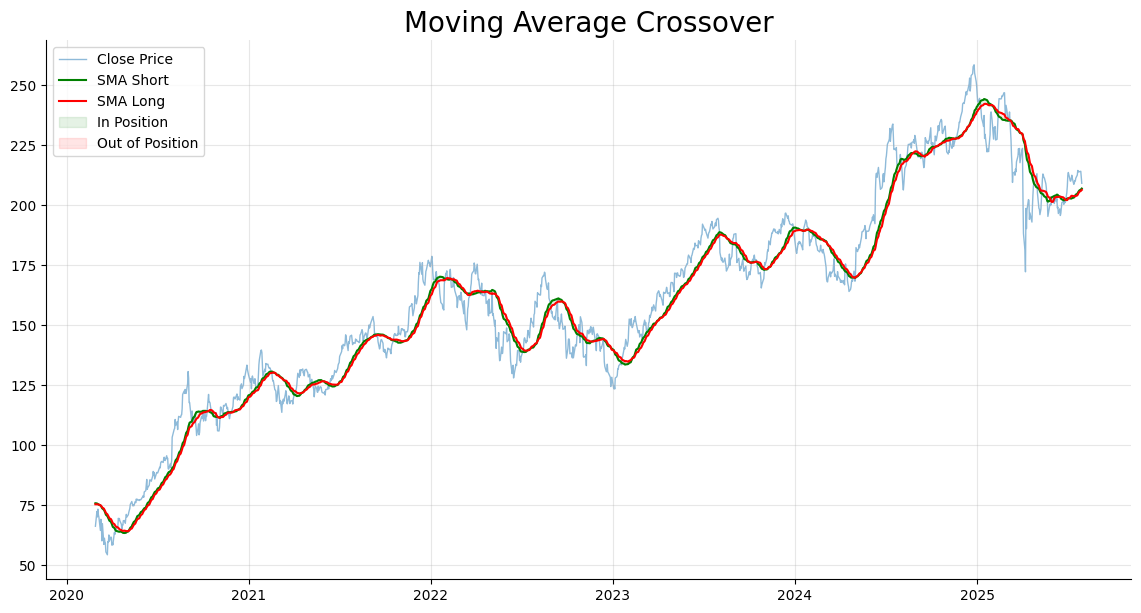

In [72]:
plot_windows(df_optimal)

(<Figure size 1400x700 with 1 Axes>,
 <Axes: title={'center': 'Buy & Hold vs Strategy Returns Over Time'}, ylabel='Cumulative Return Percentage %'>)

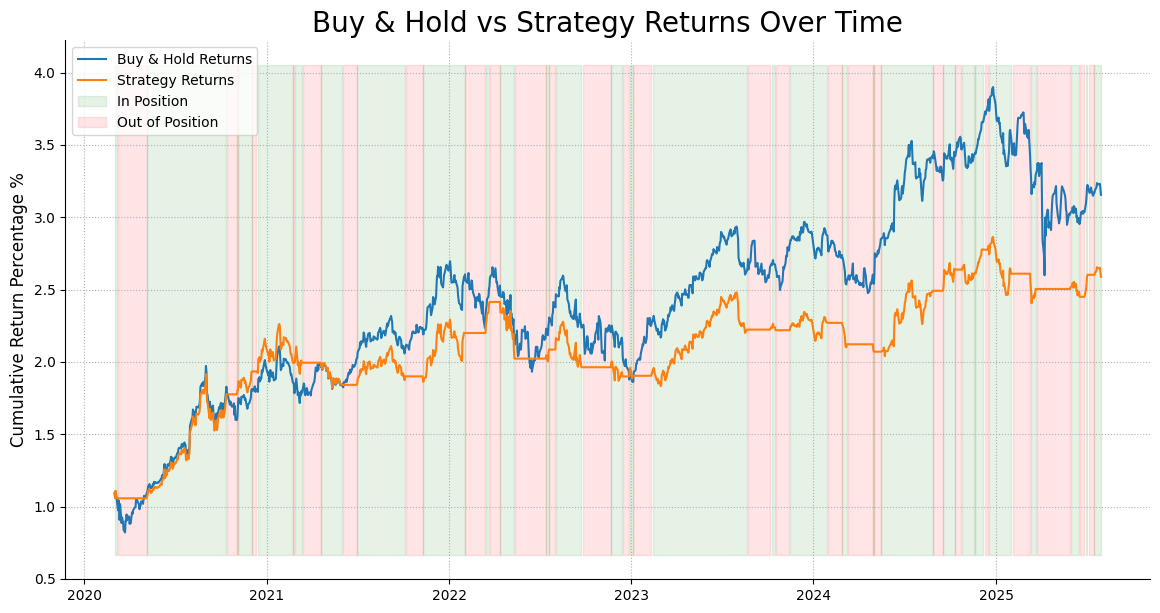

In [73]:
plot_strategy(df_optimal, in_position=df_optimal['position'])

### Testing Strong parameters with less active trades

In [74]:
df_optimal = backtest_ma_strategy(df_stock=df_aapl, short_window=5, long_window=90)
df_optimal

Price,Close,High,Low,Open,Volume,sma_short,sma_long,signal,position,price_ret,strategy_ret,price_cum_ret,strategy_cum_ret
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,,,,,,,,
Date,,,,,,,,,,,,,
2020-05-11,76.552864,77.048614,74.664615,74.873614,145946400,74.102525,70.152060,1,NaN,NaN,NaN,NaN,NaN
2020-05-12,75.678024,77.690207,75.556516,77.238191,162301200,74.814732,70.186029,1,1.0,-0.011428,-0.011428,0.988572,0.988572
2020-05-13,74.764259,76.781307,73.685262,75.857837,200622400,75.195377,70.217690,1,1.0,-0.012074,-0.012074,0.976636,0.976636
2020-05-14,75.223557,75.284311,73.276986,74.001180,158929200,75.517131,70.248086,1,1.0,0.006143,0.006143,0.982635,0.982635
2020-05-15,74.778847,74.825021,72.956217,72.990243,166348400,75.399510,70.277330,1,1.0,-0.005912,-0.005912,0.976826,0.976826
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-07-24,213.759995,215.690002,213.529999,213.899994,46022600,213.193994,205.632378,1,1.0,-0.001821,-0.001821,2.792319,2.362902
2025-07-25,213.880005,215.240005,213.399994,214.699997,40268800,213.733997,205.634159,1,1.0,0.000561,0.000561,2.793886,2.364228


(<Figure size 1400x700 with 1 Axes>,
 <Axes: title={'center': 'Moving Average Crossover'}>)

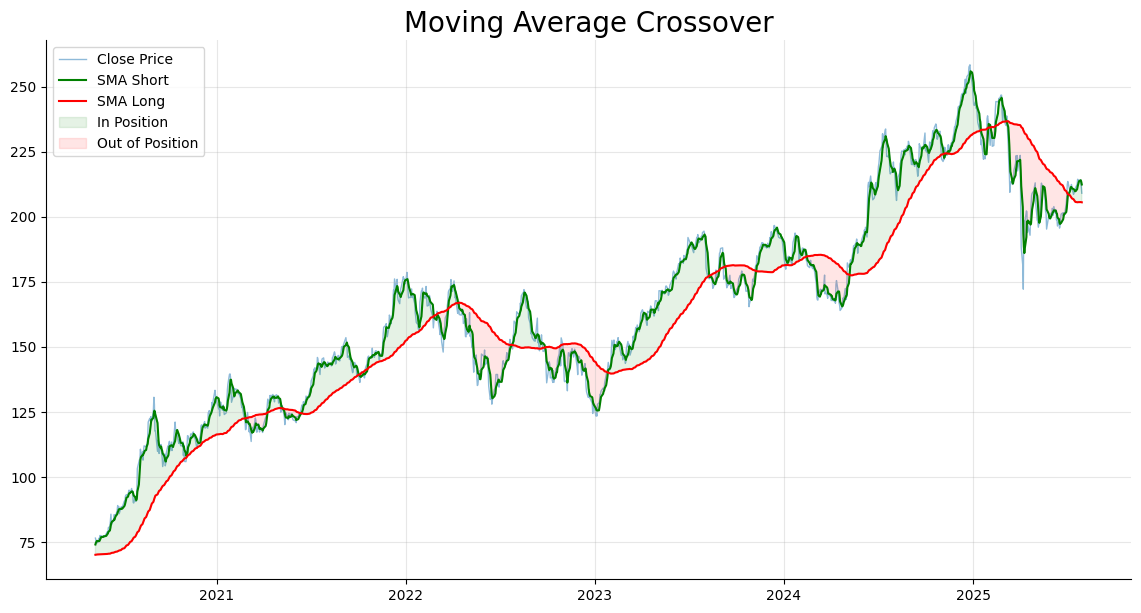

In [75]:
plot_windows(df_optimal)

(<Figure size 1400x700 with 1 Axes>,
 <Axes: title={'center': 'Buy & Hold vs Strategy Returns Over Time'}, ylabel='Cumulative Return Percentage %'>)

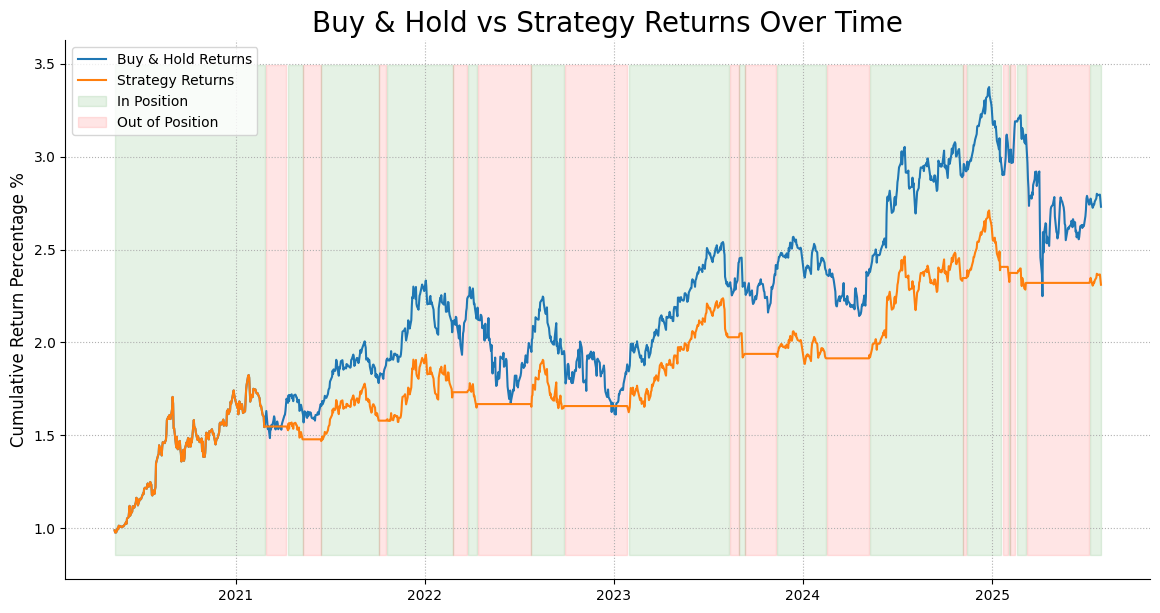

In [76]:
plot_strategy(df_optimal, in_position=df_optimal['position'])